In [189]:
import json

# Charger les données des fichiers JSON
with open('données_normales.json', 'r') as f:
    donnees_normales = json.load(f)

with open('html_injection.json', 'r') as f:
    html_injection = json.load(f)

# Ajouter la colonne attack_type
for donnee in donnees_normales:
    donnee['attack_type'] = "No attacks"

for donnee in html_injection:
    donnee['attack_type'] = "HTML injection"

# Fusionner les deux listes de données
donnees_fusionnees = donnees_normales + html_injection

# Afficher un exemple de données fusionnées
print(donnees_fusionnees[:2])

[{'method': 'GET', 'url': '/htmli_get.php', 'query_parameters': {'firstname': '<h1>Alice</h1>', 'lastname': '<div>Dupont</div>', 'address': "<script>alert('XSS')</script>", 'email': '<img src="x" onerror="alert(\'XSS\')">', 'form': 'submit'}, 'headers': {'Host': '127.0.0.1:8000', 'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/115.0', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8', 'Accept-Language': 'en-US,en;q=0.5', 'Accept-Encoding': 'gzip, deflate, br', 'Connection': 'keep-alive', 'Referer': "http://127.0.0.1:8000/htmli_get.php?firstname=%3Ch1%3EAlice%3C%2Fh1%3E&lastname=%3Cdiv%3EDupont%3C%2Fdiv%3E&address=%3Cscript%3Ealert('XSS')%3C%2Fscript%3E&email=%3Cimg%20src%3D%22x%22%20onerror%3D%22alert('XSS')%22%3E&form=submit", 'Cookie': 'security_level=0; PHPSESSID=5oat10nbn3rene9rfj94lc52i7', 'Upgrade-Insecure-Requests': '1', 'Sec-Fetch-Dest': 'document', 'Sec-Fetch-Mode': 'navigate', 'Sec-Fetch-Site': 's

In [138]:
# Sauvegarder les données fusionnées dans un fichier JSON
with open('donnees_fusionnees.json', 'w') as f:
    json.dump(donnees_fusionnees, f)

In [139]:
#import json

# Charger les données existantes
with open('donnees_fusionnees.json', 'r') as f:
    existing_data = json.load(f)

# Charger les nouvelles données générées
with open('synthetic_data.json', 'r') as f:
    new_data = json.load(f)

# Combiner les deux ensembles de données
combined_data = existing_data + new_data

# Sauvegarder les données combinées
with open('donnees_fusionnees.json', 'w') as f:
    json.dump(combined_data, f, indent=4)

In [140]:
import json
import csv

# Charger le fichier JSON
with open('donnees_fusionnees.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Ouvrir un fichier CSV en mode écriture
with open('donnees_fusionnees.csv', 'w', encoding='utf-8', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Si le JSON est une liste d'objets
    if isinstance(data, list):
        # Convertir les dictionnaires dans query_parameters et headers en chaînes JSON
        for item in data:
            if isinstance(item.get('query_parameters'), dict):
                item['query_parameters'] = json.dumps(item['query_parameters'])
            if isinstance(item.get('headers'), dict):
                item['headers'] = json.dumps(item['headers'])
        
        # Écrire les en-têtes (clés du premier élément)
        writer.writerow(data[0].keys())
        
        # Écrire les valeurs de chaque objet JSON
        for item in data:
            writer.writerow(item.values())
    else:
        print("Le fichier JSON n'est pas dans le bon format pour une conversion en CSV.")


In [35]:
import json
import pandas as pd
from urllib.parse import urlparse, parse_qs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump
from imblearn.over_sampling import SMOTE

# Lire les données depuis un fichier JSON
df = pd.read_json('donnees_fusionnees.json')

# Fonction pour détecter les mots-clés SQL
def detect_sql_keywords(query):
    sql_keywords = ["SELECT", "INSERT", "UPDATE", "DELETE", "DROP", "UNION", "ALTER", "CREATE", "EXEC", "XP_", " OR "]
    return any(keyword in query.upper() for keyword in sql_keywords)

# Fonction pour détecter les mots-clés HTML
def detect_html_keywords(query):
    html_keywords = ["<script>", "<img>", "<div>", "<h1>", "<b>", "<i>", "<span>"]
    return any(keyword in query.lower() for keyword in html_keywords)

# Fonction pour détecter les mots-clés de commandes Unix/Linux
def detect_command_keywords(query):
    command_keywords = [
        "cat", "rm", "ls", "cp", "mv", "chmod", "chown", "mkdir", "rmdir", "touch", "echo",
        "grep", "find", "tar", "zip", "unzip", "wget", "curl", "scp", "ssh", "-rf", "df", "-h", "whoami",
        "pwd", "tree", "du", "stat",
        "ps", "kill", "pkill", "top", "htop", "nice", "renice",
        "ping", "netstat", "ifconfig", "ip", "traceroute", "nslookup", "dig", "telnet", "nmap",
        "useradd", "usermod", "userdel", "passwd", "groupadd", "groups",
        "gzip", "bzip2", "xz", "7z", "rar",
        "tee", "xargs", "awk", "sed", "cut", "sort", "uniq",
        "uptime", "history", "alias", "unalias", "env", "export", "source", "time",
        ";", "|", "&", "`", "$(", "<", ">", "||", "&&"
    ]
    return any(keyword in query.lower() for keyword in command_keywords)


# Extraire les valeurs des query_parameters
def extract_values(query_parameters):
    if isinstance(query_parameters, dict):
        return ' '.join(query_parameters.values())
    return ''

# Ajouter une colonne pour détecter les mots-clés SQL
df['sql_keywords_detected'] = df['query_parameters'].apply(
    lambda x: detect_sql_keywords(extract_values(x))
)

# Ajouter une colonne pour détecter les mots-clés HTML
df['html_keywords_detected'] = df['query_parameters'].apply(
    lambda x: detect_html_keywords(extract_values(x))
)

df['command_keywords_detected'] = df['query_parameters'].apply(
    lambda x: detect_command_keywords(extract_values(x))
)

# Convertir les valeurs des query_parameters en une chaîne de caractères
df['query_parameters_values'] = df['query_parameters'].apply(lambda x: extract_values(x))

# Filtrer les données pour exclure les "HTML injection"
df = df[df['attack_type'] != 'HTML injection']

# Supprimer les colonnes inutiles et encoder les variables catégorielles
X = df[['url','query_parameters_values', 'body', 'sql_keywords_detected', 'html_keywords_detected', 'command_keywords_detected']]

# Convertir les colonnes booléennes en entiers
X.loc[:, 'sql_keywords_detected'] = X['sql_keywords_detected'].astype(int)
X.loc[:, 'html_keywords_detected'] = X['html_keywords_detected'].astype(int)
X.loc[:, 'command_keywords_detected'] = X['command_keywords_detected'].astype(int)

# Encoder les variables catégorielles
X = pd.get_dummies(X, columns=['url','query_parameters_values', 'body'], dummy_na=True)

# Sauvegarder les colonnes utilisées dans un fichier JSON
with open('columns.json', 'w') as f:
    json.dump(list(X.columns), f)

y = df['attack_type']

# Vérifier l'équilibre des classes
print(y.value_counts())

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Utiliser SMOTE pour suréchantillonner les classes minoritaires
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier l'équilibre des classes après suréchantillonnage
print(y_train_resampled.value_counts())

# Entraîner le modèle avec validation croisée
model = RandomForestClassifier()
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean()}')

# Entraîner le modèle sur l'ensemble d'entraînement complet
model.fit(X_train_resampled, y_train_resampled)

# Évaluer le modèle sur l'ensemble de test
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

C:\Users\paulj\AppData\Local\Temp\ipykernel_42612\724422322.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 

attack_type
No attack            395
SQL injection        200
Command injection    100
XSS                   53
Name: count, dtype: int64
attack_type
No attack            309
SQL injection        309
Command injection    309
XSS                  309
Name: count, dtype: int64
Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0
                   precision    recall  f1-score   support

Command injection       1.00      1.00      1.00        19
        No attack       1.00      1.00      1.00        86
    SQL injection       1.00      1.00      1.00        38
              XSS       1.00      1.00      1.00         7

         accuracy                           1.00       150
        macro avg       1.00      1.00      1.00       150
     weighted avg       1.00      1.00      1.00       150

[[19  0  0  0]
 [ 0 86  0  0]
 [ 0  0 38  0]
 [ 0  0  0  7]]


In [36]:
# Sauvegarder le modèle
dump(model, 'forensic.pkl')

['forensic.pkl']

In [37]:
df.tail(30)

method                          url  \
718   POST  /DVWA/vulnerabilities/exec/   
719   POST  /DVWA/vulnerabilities/exec/   
720   POST  /DVWA/vulnerabilities/exec/   
721   POST  /DVWA/vulnerabilities/exec/   
722   POST  /DVWA/vulnerabilities/exec/   
723   POST  /DVWA/vulnerabilities/exec/   
724   POST  /DVWA/vulnerabilities/exec/   
725   POST  /DVWA/vulnerabilities/exec/   
726   POST  /DVWA/vulnerabilities/exec/   
727   POST  /DVWA/vulnerabilities/exec/   
728   POST  /DVWA/vulnerabilities/exec/   
729   POST  /DVWA/vulnerabilities/exec/   
730   POST  /DVWA/vulnerabilities/exec/   
731   POST  /DVWA/vulnerabilities/exec/   
732   POST  /DVWA/vulnerabilities/exec/   
733   POST  /DVWA/vulnerabilities/exec/   
734   POST  /DVWA/vulnerabilities/exec/   
735   POST  /DVWA/vulnerabilities/exec/   
736   POST  /DVWA/vulnerabilities/exec/   
737   POST  /DVWA/vulnerabilities/exec/   
738   POST  /DVWA/vulnerabilities/exec/   
739   POST  /DVWA/vulnerabilities/exec/   
740   POST  /DVWA/vulnerabilities/exec/   
741   POST  /DVWA/vulnerabilities/exec/   
742   POST  /DVWA/vulnerabilities/exec/   
743   POST  /DVWA/vulnerabilities/exec/   
744   POST  /DVWA/vulnerabilities/exec/   
745   POST  /DVWA/vulnerabilities/exec/   
746   POST  /DVWA/vulnerabilities/exec/   
747   POST  /DVWA/vulnerabilities/exec/   

                                      query_parameters  \
718  {'ip': '192.168.1.50; whoami', 'Submit': 'Subm...   
719  {'ip': '10.0.0.15; uname -a', 'Submit': 'Submit'}   
720  {'ip': '172.16.10.25; ping -c 4 google.com', '...   
721  {'ip': '192.168.100.100; df -h', 'Submit': 'Su...   
722   {'ip': '10.1.1.1; top -n 1', 'Submit': 'Submit'}   
723  {'ip': '192.168.200.50; ps aux', 'Submit': 'Su...   
724  {'ip': '172.16.100.10; cat /etc/passwd', 'Subm...   
725  {'ip': '10.0.1.50; wget http://example.com/mal...   
726   {'ip': '192.168.200.25; id', 'Submit': 'Submit'}   
727  {'ip': '192.168.100.75; echo 'Hello, world!'',...   
728    {'ip': '10.1.1.200; df -h', 'Submit': 'Submit'}   
729  {'ip': '172.30.10.25; whoami', 'Submit': 'Subm...   
730  {'ip': '192.168.5.100; uname -r', 'Submit': 'S...   
731  {'ip': '10.20.30.40; rm -rf /', 'Submit': 'Sub...   
732  {'ip': '192.168.1.100; uptime', 'Submit': 'Sub...   
733  {'ip': '192.168.2.50; ps aux', 'Submit': 'Subm...   
734  {'ip': '192.168.3.60; ping -c 4 8.8.8.8', 'Sub...   
735  {'ip': '172.16.20.100; netstat -an', 'Submit':...   
736  {'ip': '10.10.10.150; cat /etc/passwd', 'Submi...   
737  {'ip': '192.168.10.10; tail -n 10 /var/log/sys...   
738    {'ip': '10.0.0.100; df -h', 'Submit': 'Submit'}   
739  {'ip': '172.16.30.20; whoami', 'Submit': 'Subm...   
740  {'ip': '192.168.5.40; uptime', 'Submit': 'Subm...   
741    {'ip': '10.10.20.200; who', 'Submit': 'Submit'}   
742  {'ip': '192.168.7.90; cat /etc/hosts', 'Submit...   
743  {'ip': '192.168.10.150; ps aux', 'Submit': 'Su...   
744  {'ip': '192.168.20.80; top -n 1', 'Submit': 'S...   
745  {'ip': '172.16.50.25; netstat -tuln', 'Submit'...   
746  {'ip': '10.0.0.50; curl http://example.com', '...   
747   {'ip': '192.168.30.110; id', 'Submit': 'Submit'}   

                                               headers  \
718  {'host': '192.168.1.50', 'user-agent': 'Mozill...   
719  {'host': '10.0.0.15', 'user-agent': 'Mozilla/5...   
720  {'host': '172.16.10.25', 'user-agent': 'Mozill...   
721  {'host': '192.168.100.100', 'user-agent': 'Moz...   
722  {'host': '10.1.1.1', 'user-agent': 'Mozilla/5....   
723  {'host': '192.168.200.50', 'user-agent': 'Mozi...   
724  {'host': '172.16.100.10', 'user-agent': 'Mozil...   
725  {'host': '10.0.1.50', 'user-agent': 'Mozilla/5...   
726  {'host': '192.168.200.25', 'user-agent': 'Mozi...   
727  {'host': '192.168.100.75', 'user-agent': 'Mozi...   
728  {'host': '10.1.1.200', 'user-agent': 'Mozilla/...   
729  {'host': '172.30.10.25', 'user-agent': 'Mozill...   
730  {'host': '192.168.5.100', 'user-agent': 'Mozil...   
731  {'host': '10.20.30.40', 'user-agent': 'Mozilla...   
7

In [192]:
print(df.columns)


Index(['method', 'url', 'query_parameters', 'headers', 'attack_type',
       'sql_keywords_detected', 'html_keywords_detected'],
      dtype='object')


In [9]:
print(df['attack_type'].value_counts())


attack_type
No attack        298
SQL injection    200
XSS               53
Name: count, dtype: int64


In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Validation croisée - Accuracy :", scores.mean())


Validation croisée - Accuracy : 1.0


In [39]:
feature_importances = model.feature_importances_
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance}")


sql_keywords_detected: 0.21121828605772494
html_keywords_detected: 0.14874907800449425
command_keywords_detected: 0.2401665608561509
url_/DVWA/vulnerabilities/exec/: 0.11716310888276162
url_/DVWA/vulnerabilities/sqli/: 0.022095919312758196
url_/DVWA/vulnerabilities/sqli/?id=1%27%20OR%20%271%27%3D%271%27%23&Submit=Submit: 2.5533097153477653e-05
url_/DVWA/vulnerabilities/sqli/?id=1&Submit=Submit: 0.00016694226675825768
url_/DVWA/vulnerabilities/sqli/?id=10%27%20OR%20%275%27%3D%275%27%23&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=10&Submit=Submit: 0.00024601755153113236
url_/DVWA/vulnerabilities/sqli/?id=100%27%20OR%20%2787%27%3D%2787%27%23&Submit=Submit: 1.0807262309161823e-05
url_/DVWA/vulnerabilities/sqli/?id=100&Submit=Submit: 0.0002461501152587579
url_/DVWA/vulnerabilities/sqli/?id=11%27%20OR%20%276%27%3D%276%27%23&Submit=Submit: 2.6204371790393406e-05
url_/DVWA/vulnerabilities/sqli/?id=11&Submit=Submit: 0.0
url_/DVWA/vulnerabilities/sqli/?id=12%27%20OR%20%277%27%3D%277%27

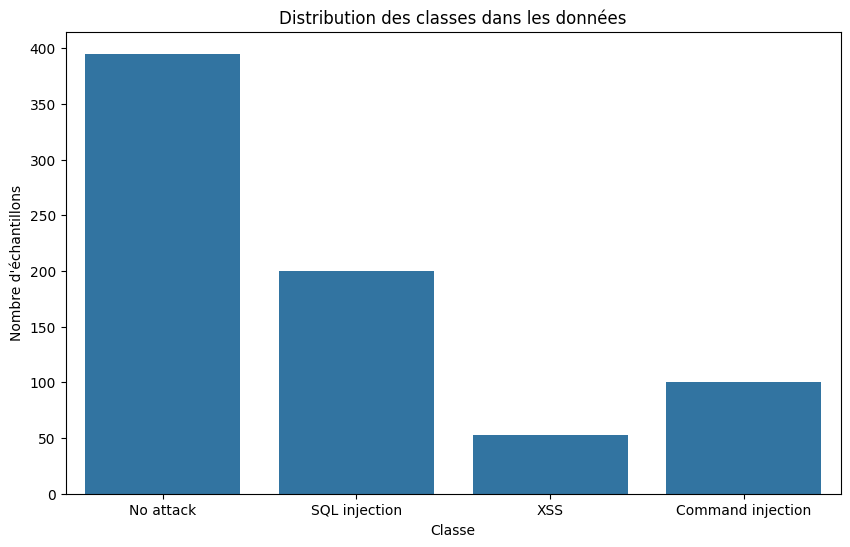

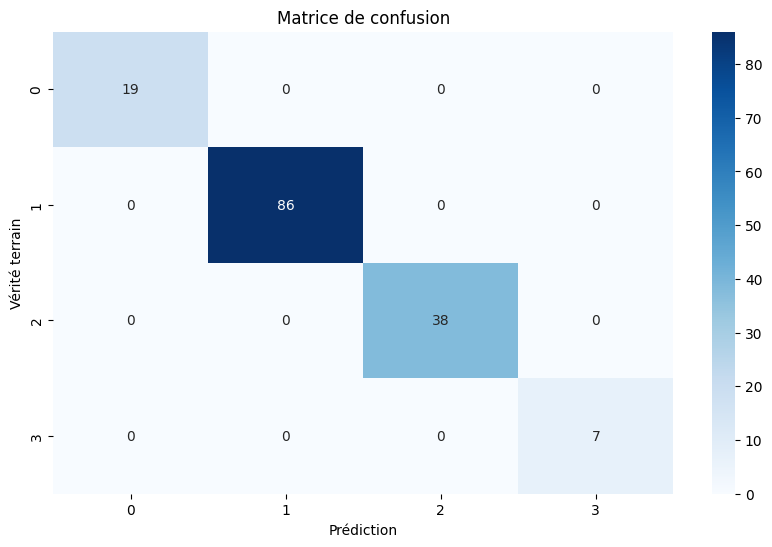

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Distribution des classes dans les données
plt.figure(figsize=(10, 6))
sns.countplot(x='attack_type', data=df)
plt.title('Distribution des classes dans les données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()
y_pred = model.predict(X_test[:len(y_test)])  # Pour s'assurer que les tailles sont égales

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# Importance des caractéristiques
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

In [41]:
import pandas as pd

# Supposons que 'model' soit votre modèle entraîné et 'X_train' soit votre ensemble de données d'entraînement
feature_importances = model.feature_importances_
features = X_train.columns

# Créer un DataFrame pour les importances des caractéristiques
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher le tableau d'importance des caractéristiques
importance_df

Feature  Importance
2                 command_keywords_detected    0.240167
0                     sql_keywords_detected    0.211218
1                    html_keywords_detected    0.148749
3           url_/DVWA/vulnerabilities/exec/    0.117163
892                                   body_    0.089575
...                                     ...         ...
1173    body_ip=176.9.119.201&Submit=Submit    0.000000
1174    body_ip=177.71.129.82&Submit=Submit    0.000000
1184    body_ip=185.46.230.58&Submit=Submit    0.000000
1240  body_ip=213.133.101.107&Submit=Submit    0.000000
1267    body_ip=51.77.240.120&Submit=Submit    0.000000

[1287 rows x 2 columns]

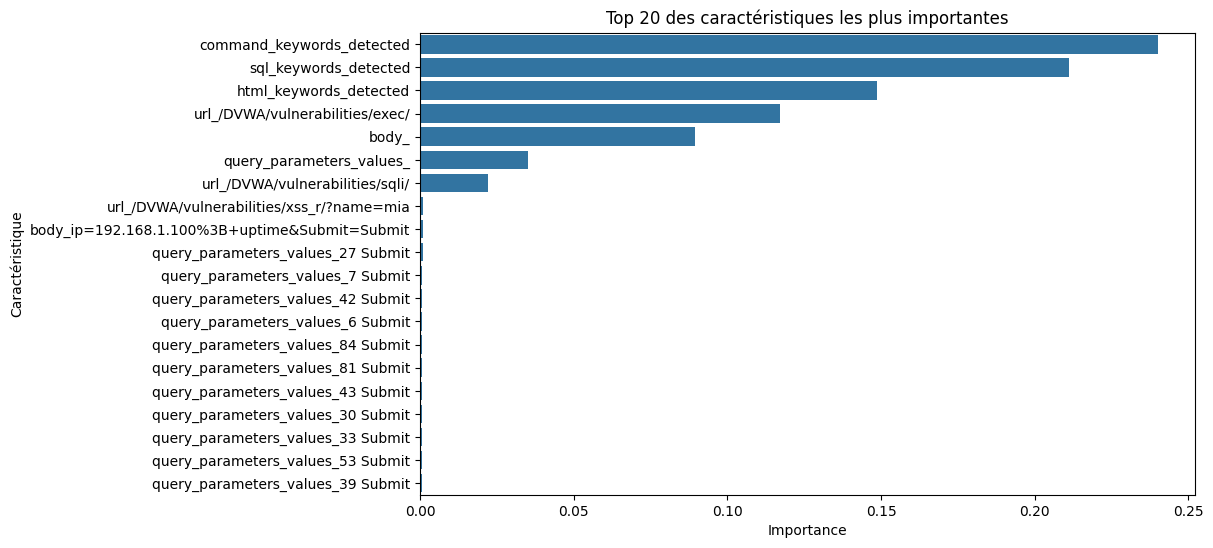

In [42]:
# Sélectionner les 20 caractéristiques les plus importantes
top_20_importance_df = importance_df.head(20)

# Afficher le tableau d'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df)
plt.title('Top 20 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()

In [43]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(model, 'forensic.pkl')

['forensic.pkl']

In [44]:
# Prédire les valeurs pour l'ensemble de test
y_pred_all = model.predict(X_test)

# Afficher les prédictions
for true_value, predicted_value in zip(y_test, y_pred_all):
    print(f"Vérité terrain: {true_value}, Prédiction: {predicted_value}")
    # Prédire les valeurs pour l'ensemble complet
    y_pred_all = model.predict(X)

    # Afficher toutes les prédictions
    for true_value, predicted_value in zip(y, y_pred_all):
        print(f"Vérité terrain: {true_value}, Prédiction: {predicted_value}")

Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No attack, Prédiction: No attack
Vérité terrain: No a

KeyboardInterrupt: 